<h2><center>Simulating a Thanksgiving Day Football Game using Copulas (and more!)</center></h2>


In [220]:
import numpy as np
import scipy.stats as sp
from scipy.linalg import eigh, cholesky
import pandas as pd
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set_style('whitegrid')
pylab.rcParams['figure.figsize'] = 10, 6

In [ ]:
years = [i for i in range(2010, 2022)]  # All years from 2010 to 2022 for our data
relevant_position = ['QB', 'WR', 'TE', 'RB']  # The FANTASY positions of interest
weekly_data = nfl.import_weekly_data(years)  # Get all weekly gamelogs from these years
depth = nfl.import_depth_charts(years)  # get all depth charts  from these years
schedules = nfl.import_schedules(years)  # get all the games from these years

### DEALING WITH DATA AND MERGING ###
depth.rename({'club_code': 'team'}, axis=1, inplace=True)  # Rename col to a more familiar name
depth = depth[depth.position.isin(relevant_position)]  # get only relevant positions
depth = depth[['season', 'team', 'week', 'depth_team', 'gsis_id', 'position']]  # slice dataframe to get features of interest
schedules = schedules[['game_id', 'season', 'week', 'home_team', 'away_team']]  # slice dataframe to get features of interest
weekly_data.rename({'player_id': 'gsis_id', 'player_display_name': 'name', 'recent_team': 'team'}, axis=1, inplace=True)  # rename columns to more familiar names
weekly_data = weekly_data[['gsis_id', 'name', 'position_group', 'team', 'season', 'week', 'fantasy_points_ppr']]  # # slice dataframe to get features of interest
weekly_data = weekly_data[weekly_data.position_group.isin(relevant_position)]  # filter dataframe to get only relevant positions
merged_data = pd.merge(weekly_data, depth, how='left', on=['gsis_id', 'season', 'week', 'team'])  # merge game log with depth chart info, so we know what the player's depth was
merged_data.drop_duplicates(inplace=True)  # handle merging errors
merged_data.dropna(inplace=True)

In [150]:
def find_game_id(row):
    """
    Using the season, week and home team or away team cols of our dataframe, find the game_id from schedules dataframe
    """
    try:
        game_id = schedules.loc[(schedules['week'] == row.week) & (schedules['season'] == row.season) & (schedules['home_team'] == row.team)].game_id.item()
    except ValueError:
        game_id = schedules.loc[(schedules['week'] == row.week) & (schedules['season'] == row.season) & (schedules['away_team'] == row.team)].game_id.item()
    return game_id

def get_opponent(row):
    """
    Find out who everyone was facing that week, so we can find correlations between a player and opponents
    """
    game = schedules.loc[(schedules['game_id'] == row.game_id)]
    if row.team == game.home_team.item():
        return game.away_team.item()
    else:
        return game.home_team.item()

def get_depth_pos(row, team):
    """
    returns: either POS or POS_OPP depending on whether the player is on the home or away team.
    """
    if row.team != team:
        return f'{row.position_group}{row.depth_team}_OPP'
    else:
        return f'{row.position_group}{row.depth_team}'

merged_data['game_id'] = merged_data.apply(find_game_id, axis=1)
merged_data['opponent'] = merged_data.apply(get_opponent, axis=1)

def get_depth_pivot(team):
    team_or_opponent_log = merged_data.loc[(merged_data['team'].isin([team])) | (merged_data['opponent'].isin([team]))]
    team_or_opponent_log['depth_pos'] = team_or_opponent_log.apply(get_depth_pos, axis=1, team=team)
    pivot_tbl = team_or_opponent_log.pivot_table('fantasy_points_ppr', ['season', 'week'], 'depth_pos')
    pivot_tbl.fillna(0, inplace=True)
    return pivot_tbl

def get_all_pos_fpts_by_game(df):
    pivot_tables = []
    for team in df.team.unique():
        pivot_tables.append(get_depth_pivot(team))
    concat = pd.concat(pivot_tables, axis=0)
    concat.reset_index(inplace=True)
    concat.drop(columns=['season', 'week', 'QB3', 'QB3_OPP', 'TE3', 'TE3_OPP'], inplace=True)
    return concat

all_games = get_all_pos_fpts_by_game(merged_data)
all_games = all_games[['QB1', 'QB2', 'RB1', 'RB2', 'RB3', 'TE1', 'TE2', 'WR1', 'WR2', 'WR3', 'QB1_OPP', 'QB2_OPP', 'RB1_OPP', 'RB2_OPP', 'RB3_OPP', 'TE1_OPP', 'TE2_OPP', 'WR1_OPP', 'WR2_OPP', 'WR3_OPP']]

## Our Game

### NYG @ DAL (4:30 PM, 11/24)



In [292]:
class Player:
    def __init__(self, name, depth_pos, dist):
        self.name = name
        self.depth_pos = depth_pos
        self.dist = dist
        self.uncorr_sample = dist.rvs(size=1000)
        self.copula_simmed_fpts = []
        self.cholesky_simmed_fpts = []


class Team:
    def __init__(self, tm_depth_dict: dict[str, Player]):
        self.QB1 = tm_depth_dict.get('QB1')
        self.QB2 = tm_depth_dict.get('QB2')
        self.RB1 = tm_depth_dict.get('RB1')
        self.RB2 = tm_depth_dict.get('RB2')
        self.RB3 = tm_depth_dict.get('RB3')
        self.TE1 = tm_depth_dict.get('TE1')
        self.TE2 = tm_depth_dict.get('TE2')
        self.WR1 = tm_depth_dict.get('WR1')
        self.WR2 = tm_depth_dict.get('WR2')
        self.WR3 = tm_depth_dict.get('WR3')

class Game:
    def __init__(self, home_team: Team, away_team: Team, all_games: pd.DataFrame, sims: int, seed: int, method='cholesky'):
        self.home_team = home_team
        self.away_team = away_team
        self.sims = sims
        self.seed = seed
        self.method = method
        self.all_players = []
        self.copula = self.init_copula(all_games.corr(), sims, seed)
        self.sample_from_copula()

        self.c = self.get_C(all_games.corr())
        self.parse_linalg_corr_sample()

        self.player_dict = self.build_player_dict()

    @staticmethod
    def init_copula(corr_matrix, simulations, seed):
        """
            Initialize the copula given the correlation matrix, which covers correlations between every position.

            corr: np.ndarray version of our correlation matrix
            r0: an array of shape (1, len(corr_matrix)) filled with zeroes that we use for the mean
            rand_norm_vals: take a multivariate sample with means of r0 given our correlation matrix.
                            returns an array of shape (len(corr_matrix), # sims)
            rand_uniform_vals: Normalize the random variables we sampled to be between [0, 1]
        """
        np.random.seed(seed=seed)
        corr = np.array(corr_matrix)
        r0 = [0] * corr.shape[0]
        rand_norm_vals = sp.multivariate_normal(mean=r0, cov=corr).rvs(simulations)  # <--- we are drawing a matrix of random variables here
        rand_uniform_vals = sp.norm.cdf(rand_norm_vals)
        return pd.DataFrame(rand_uniform_vals, columns=corr_matrix.columns)

    def sample_from_copula(self):
        for key, val in self.home_team.__dict__.items():
            val.copula_simmed_fpts = val.dist.ppf(self.copula[key].values)
            self.all_players.append(val)
        for key, val in self.away_team.__dict__.items():
            val.copula_simmed_fpts = val.dist.ppf(self.copula[f'{key}_OPP'].values)
            self.all_players.append(val)

    def get_C(self, corr_matrix):
        """
        Compute a matrix C for which CC^T = cov_matrix

        Via cholesky decomp or using eigenvectors & eigenvals

        :return: matrix C of shape(sims, len(cov_matrix))
        """
        if self.method == 'cholesky':
            c = cholesky(corr_matrix, lower=True)
        else:
            evals, evecs = eigh(corr_matrix)
            c = np.dot(evecs, np.diag(np.sqrt(evals)))
        return c

    def build_player_matrix(self):
        """
        Since each player has their own array of uncorrelated samples, we have to build a matrix that we can take the dot product of. The columns are simply each player, where home players make up the first 11 and away players make up the second 11 (suffix _OPP in our covariance matrix). Each player is represented by a ROW.
        """
        array = [i.uncorr_sample for i in self.all_players]
        return np.array(array)

    def get_linalg_corr_sample(self, c):
        """
        Get the dot project of c and our uncorrelated samples
        """
        corr_samples = np.dot(c, self.build_player_matrix())
        return corr_samples

    def parse_linalg_corr_sample(self):
        """
        Apply our correlated samples to each player
        :return:
        """
        for idx, row in enumerate(self.get_linalg_corr_sample(self.c)):
            self.all_players[idx].cholesky_simmed_fpts = row

    def build_player_dict(self):
        """
        Build a dictionary so we can access players by name
        :return:
        """
        player_dict = {}
        for player in self.all_players:
            player_dict[player.name] = player

        return player_dict

    def plot_corr(self, player1_name, player2_name, method='copula'):
        player1: Player = self.player_dict[player1_name]
        player2: Player = self.player_dict[player2_name]

        if method == 'copula':
            min1, max1 = player1.copula_simmed_fpts.min(), player1.copula_simmed_fpts.max()
            min2, max2 = player2.copula_simmed_fpts.min(), player2.copula_simmed_fpts.max()
            data1 = player1.copula_simmed_fpts
            data2 = player2.copula_simmed_fpts
        else:
            min1, max1 = player1.cholesky_simmed_fpts.min(), player1.copula_simmed_fpts.max()
            min2, max2 = player2.cholesky_simmed_fpts.min(), player2.copula_simmed_fpts.max()
            data1 = player1.cholesky_simmed_fpts
            data2 = player2.cholesky_simmed_fpts
        min1_uncorr, max1_uncorr = player1.uncorr_sample.min(), player1.uncorr_sample.max()
        min2_uncorr, max2_uncorr = player2.uncorr_sample.min(), player2.uncorr_sample.max()
        data1_uncorr = player1.uncorr_sample
        data2_uncorr = player2.uncorr_sample
        h_corr = sns.jointplot(x=data1, y=data2, xlim=(min1, max1), ylim=(min2, max2), kind='kde')
        h_corr.set_axis_labels(f'{player1.name} {player1.depth_pos} {method}', f'{player2.name} {player2.depth_pos} {method}')
        h_uncorr = sns.jointplot(x=data1_uncorr, y=data2_uncorr, xlim=(min1_uncorr, max1_uncorr), ylim=(min2_uncorr, max2_uncorr), kind='kde')
        h_uncorr.set_axis_labels(f'{player1.name} {player1.depth_pos} uncorrelated', f'{player2.name} {player2.depth_pos} uncorrelated')





### Setting up our teams using output from my model

In [293]:
dal = Team({
    "QB1": Player("Dak Prescott", "QB1", sp.hypsecant(16.5853, 3.7163)),
    "QB2": Player("Cooper Rush", "QB2", sp.weibull_min(0.6065, 0, 3.1723)),
    "RB1": Player("Ezekiel Elliott", "RB1", sp.alpha(6.4545, -27.0641, 256.3494)),
    "RB2": Player("Tony Pollard", "RB2", sp.fisk(3.3622, 0.7097, 10.1316)),
    "RB3": Player("Malik Davis", "RB3", sp.alpha(0.5555, -1.3639, 3.000)),
    "TE1": Player("Dalton Schultz", "TE1", sp.fisk(5.8429, -7.1984, 14.3314)),
    "TE2": Player("Peyton Hendershot", "TE2", sp.genlogistic(1147.34, -11.2756, 1.7954)),
    "WR1": Player("CeeDee Lamb", "WR1", sp.genlogistic(2.6236, 7.3227, 5.5026)),
    "WR2": Player("Michael Gallup", "WR2", sp.hypsecant(8.3781, 3.1373)),
    "WR3": Player("Jalen Tolbert", "WR3", sp.wald(-1.0848, 5.5399)),
})

nyg = Team({
    "QB1": Player("Daniel Jones", "QB1", sp.hypsecant(15.5364, 3.2092)),
    "QB2": Player("Tyrod Taylor", "QB2", sp.weibull_min(0.6504, 0, 3.9129)),
    "RB1": Player("Saquon Barkley", "RB1", sp.genlogistic(5.9518, 3.4236, 5.1479)),
    "RB2": Player("Matt Breida", "RB2", sp.beta(0.7678, 5.3652, 0.5040106584795225, 42.0175)),
    "RB3": Player("Gary Brightwell", "RB3", sp.alpha(1.1133, -1.7569, 4.9373)),
    "TE1": Player("Tanner Hudson", "TE1", sp.rice(0, -2.8490, 9.4663)),
    "TE2": Player("Chris Myarick", "TE2", sp.gamma(1.84419, -1.206, 3.1536)),
    "WR1": Player("Darius Slayton", "WR1", sp.fisk(7.7064, -13.7441, 24.7939)),
    "WR2": Player("Kenny Golladay", "WR2", sp.wald(0.49, 7.8601)),
    "WR3": Player("Marcus Johnson", "WR3", sp.pearson3(1.2939, 3.8905, 3.8184)),
})

nyg_at_dal = Game(dal, nyg, all_games, sims=1000, seed=42, method='cholesky')

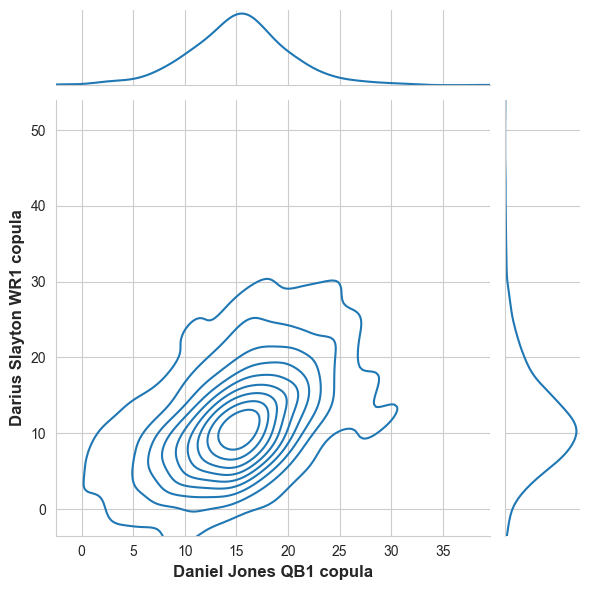

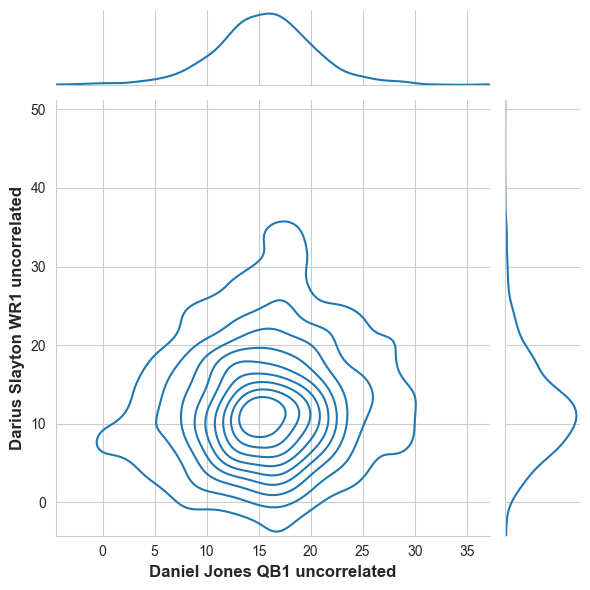

In [294]:
nyg_at_dal.plot_corr('Daniel Jones', 'Darius Slayton')

In [ ]:
nyg